#### Getting the Grid

In [1]:
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
from astropy.io import fits
homedir = os.path.expanduser('~')
from Starfish.grid_tools import CIFISTGridInterface
import matplotlib.pyplot as plt

In [2]:
grid = CIFISTGridInterface(path=f"{homedir}/uoedrive/data/BTSettltest",air=True, wl_range=(1.5e4, 2.5e4))
grid.points = [np.array([1400, 1500, 1550]), np.array([5, 5.5])]

From here, we will want to set up our HDF5 interface that will allow us to go on to using the spectral emulator, but first we need to determine our model subset and instrument.

### Setting up the HDF5 Interface

We set up an HDF5 interface in order to allow much quicker reading and writing than compared to loading FITS files over and over again. In addition, when considering the application to our likelihood methods, we know that for a given dataset, any effects characteristic of the instrument can be pre-applied to our models, saving on computation time during the maximum likelihood estimation.

In [3]:
from Starfish.grid_tools.instruments import IGRINS_K
from Starfish.grid_tools import HDF5Creator
ranges = [[1400, 1550], [5.0, 5.5]]  # T, logg, Z
if os.path.exists("BTSettl_K_grid.hdf5"):
    os.remove("BTSettl_K_grid.hdf5")
creator = HDF5Creator(
    grid, "BTSettl_K_grid.hdf5", instrument=IGRINS_K(), wl_range=(1.5e4, 2.5e4), ranges=ranges
)

In [5]:
creator.process_grid()

Processing [1550.     5.5]: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


### Setting up the Spectral Emulator

Once we have our pre-processed grid, we can make our spectral emulator and train its Gaussian process hyperparameters.

In [6]:
from Starfish.emulator import Emulator

# can load from string or HDF5Interface
emu = Emulator.from_grid("BTSettl_K_grid.hdf5")
emu

Emulator
--------
Trained: False
lambda_xi: 1.000
Variances:
	10000.00
	10000.00
	10000.00
Lengthscales:
	[ 300.00  1.50 ]
	[ 300.00  1.50 ]
	[ 300.00  1.50 ]
Log Likelihood: -1297.62

In [7]:
%time emu.train(options=dict(maxiter=1e5))
emu

CPU times: user 455 ms, sys: 3.47 ms, total: 458 ms
Wall time: 458 ms


Emulator
--------
Trained: True
lambda_xi: 1.002
Variances:
	731730.75
	653946.75
	162408.77
Lengthscales:
	[ 200.57  1.49 ]
	[ 200.00  1.25 ]
	[ 200.00  1.31 ]
Log Likelihood: -99.20

<div class="alert alert-info">
  
**Note:** If the emulator does not optimize the first time you use ``train``, just run it again. You can also tweak the arguments passed to ``scipy.optimize.minimize`` by passing them as keyword arguments to the call.
    
</div>

<div class="alert alert-warning">

**Warning:** Training the emulator will take on the order of minutes to complete. The more eigenspectra that are used as well as the resolution of the spectrograph will mainly dominate this runtime.

</div>

We can do a sanity check on the optimization by looking at slice of the emulator's parameter space and the corresponding Gaussian process fit. We should see a smooth line connecting all the parameter values with some uncertainty that grows with large gaps or turbulent weights.

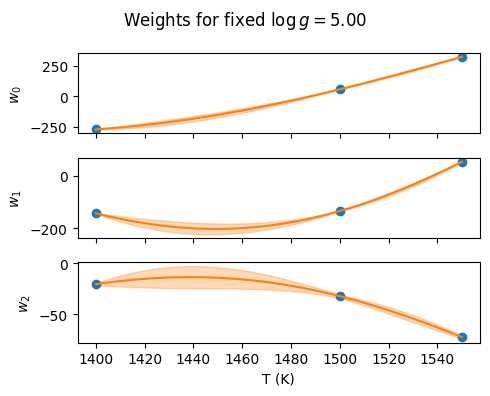

In [17]:
%matplotlib inline
import itertools
emulator = emu 

T = np.unique(emulator.grid_points[:, 0])
logg = np.unique(emulator.grid_points[:, 1])
params = np.array(list(itertools.product(T, logg[:1])))
idxs = np.array([emulator.get_index(p) for p in params])
weights = emulator.weights[idxs.astype("int")].T
if emulator.ncomps < 4:
    fix, axes = plt.subplots(
        emulator.ncomps, 1, sharex=True, figsize=(5, (emulator.ncomps - 1) * 2)
    )
else:
    fix, axes = plt.subplots(
        int(np.ceil(emulator.ncomps / 2)),
        2,
        sharex=True,
        figsize=(13, (emulator.ncomps - 1) * 2),
    )
axes = np.ravel(np.array(axes).T)
[ax.set_ylabel(f"$w_{i}$") for i, ax in enumerate(axes)]
for i, w in enumerate(weights):
    axes[i].plot(T, w, "o")

Ttest = np.linspace(T.min(), T.max(), 100)
Xtest = np.array(list(itertools.product(Ttest, logg[:1])))
mus = []
covs = []
for X in Xtest:
    m, c = emulator(X)
    mus.append(m)
    covs.append(c)
mus = np.array(mus)
covs = np.array(covs)
sigs = np.sqrt(np.diagonal(covs, axis1=-2, axis2=-1))
for i, (m, s) in enumerate(zip(mus.T, sigs.T)):
    axes[i].plot(Ttest, m, "C1")
    axes[i].fill_between(Ttest, m - 2 * s, m + 2 * s, color="C1", alpha=0.3)
axes[-1].set_xlabel("T (K)")
plt.suptitle(f"Weights for fixed $\log g={logg[0]:.2f}$")
plt.tight_layout()

If we are satisfied, let's save this emulator and move on to fitting some data.

In [18]:
emu.save("BTSettl_K_emu.hdf5")